In [31]:
import numpy as np
from scipy import optimize
from scipy.stats import bernoulli
import math
from matplotlib import pyplot as plt
from scipy.special import psi

## Maximum Likelihood Estimation 
### Optimization Point of View

### Formalizing MLE of Bernuolli Distributions
Recall that in our previous MLE application, we were trying to estimate the probability of "H" showing after a random coin flip of a specific loaded coin. We did not focus on the details of how to derive such MLE estimation (where we were simply averaging the number of times where "H" shows up). Let us investigate this in more detail here.

**Problem Source:** We borrow and modify the problem from Section 24.1 of ```Shalev-Shwartz, S. & Ben-David, S. (2014). Understanding machine learning: From theory to algorithms. Cambridge university press.```

**Problem Description:** A drug company discovered a new drug that is hoped to treat COVID-19 in high-risk groups. You have a random sample of $n$ high-risk volunteering people and give each of them the new drug. Such training set can be represented as $\mathcal{X} = (x_1, \ldots, x_n)$ where $x_i =1$ if the $i$-th patient is recovered and $x_i = 0$ otherwise. We assume the true probability of survival is $\theta$ for a single individual, i.e., the survival has a Bernuolli distribution. 

**Question:** How would you estimate $\theta$ from $\mathcal{X}$? 

**Answer:** Previously we used the following estimation that is *very* intuitive
$$\hat{\theta} = \frac{1}{n} \sum_{i=1}^n x_i.$$
But what is special about this estimation? The first advantage is that it is unbiased. To see this, recall that when we do not see $\mathcal{X}$ yet, we know that it is a collection of $n$ Bernuolli variables $X_i, \ i=1,\ldots,n$. We can derive:
\begin{align*}
\mathbb{E}_{\mathcal{X}} [\hat{\theta}] & = \frac{1}{n}\mathbb{E}\left[ {\sum_{i=1}^n X_i} \right] \\
& = \frac{1}{n} \left( \sum_{i=1}^n \mathbb{E}\left[ X_i \right] \right) \\
& = \frac{1}{n} \left( \sum_{i=1}^n  1 \cdot \mathbb{P}[X_i = 1] + 0 \cdot \mathbb{P}[X_i = 0] \right) \\
& = \frac{1}{n} \left( \sum_{i=1}^n  \theta \right) \\
& = \theta.
\end{align*}
So we can see that, for a randomly drawn sample of $n$ people, we expect our estimator $\hat{\theta}$ to be equal to $\theta$. This is the property telling we have an *unbiased estimator of $\theta$*. Let us summarize this process in a case study where $n=100$ and $\theta = 0.8$.

In [32]:
np.random.seed(0)
theta = 0.8 #probability of survival
n = 100 #number of patients in the trial
sample = bernoulli.rvs(theta, size = 100) #take a single sample of 100-patients
estimator = np.mean(sample)
print(r"The true value of theta is", theta, "and our unbiased estimation is", estimator)

The true value of theta is 0.8 and our unbiased estimation is 0.85


As we observe, there is a difference between $\hat{\theta}$ and $\theta$, so we have some bias in our estimation. Then why do we claim $\hat{\theta}$ is unbiased? The answer is, our $\hat{\theta}$ only sees a single sample of $100$ patients, and there is no guarantee that these $100$ patients will have precisely $80$ survival (otherwise we are living in a world with no uncertainty). What unbiased estimator means is that, if we have the above experiment a lot of times, then the average of our estimations will be $0.8$. Let us observe this.

In [33]:
simulations = 10000 #large number to iterate above experiment. We can think this as 10000 different worlds.
theta = 0.8 #probability of survival
n = 100 #number of patients in the trial
estimators = np.zeros(simulations)
for sim in range(simulations):
    sample_temp = bernoulli.rvs(theta, size = 100) #take a new sample of 100-patients
    estimators[sim] = np.mean(sample_temp)
average_estimator = np.mean(estimators)
print("The average of all estimations is", np.round(average_estimator,3))

The average of all estimations is 0.799


**Discussion:** Now we understand what is an *unbiased estimator* of the true parameter of the underlying distribiution. In most cases, the *unbiased estimator* is not necessarily the *maximum likelihood estimator* (if, for example, $X_i$ were normally distributed, the maximum likelihood standard deviation estimator would not be unbiased). So it is important to understand the key difference between having an *unbiased estimator* and a *maximum likelihood estimator*. Let us first define the maximum likelihood estimation principle, which is very interesting both practically and philosophically.

**<span style="color:blue">MLE STEP 1: Derive the likelihood function. </span>**
We know that there is a true $\theta$ from which each of the $X_i$ in our $\mathcal{X}$ is sampled, and the realizations are $X_i = x_i$ for all $i=1,\ldots,n$. Instead of asking "does averaging $x_i$ work", here we ask "which $\theta \in [0,1]$ would be the *most likely* to generate such a sample $\mathcal{X}$?". For this purpose, we first write the probability of seeing such $X_i = x_i$ sequence for $i = 1,\ldots,n$ for an arbitrary $\theta$.
\begin{align*}
\mathbb{P}[X_1 =x_1, \ldots, X_n = x_n] &= \prod_{i=1}^n \mathbb{P}[X_i =x_i] \\
& =\prod_{i=1}^n  \{\theta \text{ if $x_i = 1$; otherwise } 1-\theta \} \\
& =\prod_{i=1}^n  \theta^{x_i} (1- \theta)^{1 - x_i} \\
& = \theta^{\sum_{i=1}^n x_i} (1-\theta)^{\sum_{i=1}^n (1-x_i)}.
\end{align*}
The *maximum likelihood estimator* $\theta^\star$ would be the $\theta$ that maximizes this probability. However, maximizing a function $\theta^{85} \cdot (1-\theta)^{15}$ is quite hard for most computers and solvers. How can we overcome this issue?

**<span style="color:blue">MLE STEP 2: Derive the log-likelihood function. </span>**
We take $\ell(\theta) := \log \mathbb{P}[X_1 =x_1, \ldots, X_n = x_n]$ as the log-likelihood function. The trick is, logarithm is a non-decreasing function. Hence, the $\theta^\star$ that maximizes the likelihood function will also maximize the log-likelihood function. In this case, we apply simple logarithm properties to obtain:
\begin{align*}
\ell(\theta) & = \log \left[ \theta^{\sum_{i=1}^n x_i} (1-\theta)^{\sum_{i=1}^n (1-x_i)} \right] \\
&=\log \left[ \theta^{\sum_{i=1}^n x_i} \right] +  \log \left[ (1-\theta)^{\sum_{i=1}^n (1-x_i)} \right] \\
& = \left(\sum_{i=1}^n x_i \right) \log [\theta] + \left(\sum_{i=1}^n (1-x_i)\right) \log [1 - \theta]
\end{align*}

**<span style="color:blue">MLE STEP 3: Find the $\theta^\star$ that optimizes the log-likelihood function. </span>**
This function we just derived is a sum of two logarithms (with linear inputs of $\theta$), hence log-likelihood in this case is a concave function (it is important to remember that the $x_i$'s are fixed, hence the only variable is $\theta$). Taking the first order conditions would therefore give us the global maximizer. Formally:
\begin{align*}
\dfrac{ \mathrm{d}\left[ \left(\sum_{i=1}^n x_i \right) \log [\theta] + \left(\sum_{i=1}^n (1-x_i)\right) \log [1 - \theta] \right]}{\mathrm{d} \theta} &= \frac{\sum_{i=1}^n x_i}{\theta} - \frac{\sum_{i=1}^n (1-x_i)}{1-\theta} \\
& = \frac{(1-\theta)\sum_{i=1}^n x_i}{(1-\theta)\theta} - \frac{\theta \sum_{i=1}^n (1-x_i)}{(1-\theta)\theta}
\end{align*}
and as the optimal $\theta^\star$ sets this expression to $0$, we shall have 
\begin{align*}
& (1-\theta^\star)\sum_{i=1}^n x_i = \theta^\star \sum_{i=1}^n (1-x_i)\\
\iff & \sum_{i=1}^n x_i - \theta^\star \sum_{i=1}^n x_i = \theta^\star n - \theta^\star \sum_{i=1}^n x_i \\
\iff & \sum_{i=1}^n x_i = \theta^\star n  \\
\iff & \theta^\star = \frac{\sum_{i=1}^n x_i }{n}.
\end{align*}
We just deried $\theta^\star$. Notice that this is identical to $\hat{\theta}$, the unbiased estimator we previously derived. So, the naive estimator that we have been using turns out to be the maximum likelihood estimator. 

Note: due to the arithmetic operations we implicitly assumed $\theta$ is not equal to $0$ or $1$. If true $\theta$ was equal to $0$ or $1$, then all of $x_i$ we observe would be equal to each other, and in this case $\theta^\star = \hat{\theta} = \theta$ trivially follows.

**Exercise Question:** Can you apply Bootstrapping to construct a confidence interval on $\theta$ when you are only given the realization of $\mathcal{X}$?

### MLE in the case of a continuous variable
Recall that previously we defined the likelihood function as $\mathbb{P}[X_1 =x_1, \ldots, X_n = x_n]$ and since we were working with independent variables this was equal to $\prod_{i=1}^n \mathbb{P}[X_i = x_i]$. What if we have a continuous variable? For example, if $X_1$ is normally distributed, what is $\mathbb{P}[X_1 = x_1]$? The answer is $0$, since a continuous variable on a non-empty support can take uncountably many values, so intuitively there is no chance that we will see a specific value. So the previous application of MLE is not applicable here as the probability of seeing any sample will be $0$ for a continuous variable. 

To fix this issue, we define the 'likelihood' slighlty different than the 'probability'. Recall that although the probability of $\mathbb{P}[X_1 = x_1]$ is $0$, we have that $\mathbb{P}[X_1 \in [x_1 - \epsilon, x_1 + \epsilon]] > 0$ in most cases for small $\epsilon$. The intuition behind is that although the event $X_1 = x_1$ is impossible to have, there is a positie probability that $X_1$ will be in a (small) neighborhood of $x_1$. We therefore define the likelihood of the event $X_1 = x_1$ via the probability density of $x_1$ assigned by the distribution of $X_1$.

**Exercise Question** Let $X$ be a continuous random variable with density function $f(\cdot)$. What is the relation between $\mathbb{P}[X \in [x - \epsilon, x + \epsilon]]$ for small $\epsilon$, and the denisty $f(x)$? 

Hence, for continuous variables, the likelihood of seeing $\mathcal{X} = \{X_1 = x_1, \ X_2 = x_2, \ldots, \ X_n = x_n\}$ (where $X_i$ are i.i.d. continuous variables) is
$$L( \mathcal{X} ) = \prod_{i=1}^n f(x_i).$$
In general, the likelihood is a function of the parameters that define the density function $f$, and we also represent them in the likelihood notation. For example, if $f$ is parametrized by some $\alpha, \ \beta$, we denote:
$$L( \mathcal{X} | \alpha, \beta) = \prod_{i=1}^n f(x_i).$$

### MLE of Normal Distributions
Let us similarly define $\mathcal{X} = \{X_1 = x_1, \ X_2 = x_2, \ldots, \ X_n = x_n \}$ as the sample we have. This time, $X_i$ are i.i.d. normal variables with mean $\mu$ and standard deviation $\sigma$. Let us simulate this for $\mu = 1$ and $\sigma = 0.5$ (but recall that in MLE we do not know these values, we just see $\mathcal{X}$!

In [34]:
np.random.seed(0)
sigma = 0.5 #std
mu = 1 #mean
n = 200 #let us hage n = 200
sample = np.random.normal(mu, sigma, n)

Recall that the unbiased estimation of $\mu$ and $\sigma$ are given as
\begin{align*}
& \hat{\mu} = \dfrac{1}{n} \sum_{i=1}^n x_i \\
& \hat{\sigma} = \sqrt{\dfrac{1}{n-1} \sum_{i=1}^n (x_i - \hat{\mu})^2}
\end{align*}
Let us next derive the maximum likelihood estimations of $\mu$ and $\sigma$ next by using the previous steps.

**<span style="color:blue">MLE STEP 1: Derive the likelihood function. </span>**
Since $f(x) = \dfrac{1}{\sigma \sqrt{2\pi}} \exp \left[ - \dfrac{(x- \mu)^2}{2 \sigma^2} \right]$ is the density function of a normal variable with mean $\mu$ and standard deviation $\sigma$, we derive:
$$L( \mathcal{X} | \mu, \sigma) = \prod_{i=1}^n f(x_i) = \dfrac{1}{(\sigma \sqrt{2\pi})^n} \prod_{i=1}^n \exp \left[ - \dfrac{(x_i - \mu)^2}{2 \sigma^2} \right] = \dfrac{1}{(\sigma \sqrt{2\pi})^n} \exp \left[ - \dfrac{\sum_{i=1}^n (x_i - \mu)^2}{2 \sigma^2} \right].$$

**<span style="color:blue">MLE STEP 2: Derive the log-likelihood function. </span>**
It immediately follows that:
\begin{align*}
\ell(x | \mu, \sigma) &= \log \left(\dfrac{1}{(\sigma \sqrt{2\pi})^n} \exp \left[ - \dfrac{\sum_{i=1}^n (x_i - \mu)^2}{2 \sigma^2} \right] \right) \\
& = - n \log(\sigma \sqrt{2 \pi}) - \dfrac{\sum_{i=1}^n (x_i - \mu)^2}{2 \sigma^2}
\end{align*}

**<span style="color:blue">MLE STEP 3: Find the $\mu^\star, \ \sigma^\star$ values that maximize the log-likelihood function. </span>**
As before, the log-likelihood function is concave in $\mu$ and $\sigma$, hence taking the first order conditions would give us the solution that maximizes the log-likelihood. To this end, we derive:
\begin{align*}
& \dfrac{\partial \ell (x | \mu, \sigma)}{\partial \mu} = \dfrac{1}{2\sigma^2} \sum_{i=1}^n (x_i - \mu) \\
& \dfrac{\partial \ell (x | \mu, \sigma)}{\partial \sigma} = - \dfrac{n}{\sigma} + \dfrac{1}{\sigma^3} \sum_{i=1}^n (x_i - \mu)^2.
\end{align*}
Setting both expressions to $0$ give us the MLE solutions $\mu^\star, \ \sigma^\star$ as:
\begin{align*}
& \mu^\star = \dfrac{1}{n} \sum_{i=1}^n x_i\\
& \sigma^\star = \sqrt{\dfrac{1}{n} \sum_{i=1}^n (x_i - {\mu^\star})^2}.
\end{align*}
Notice that $\mu^\star$ is the same as the unbiased estimate $\hat{\mu}$. However, $\sigma^\star$ is different than the unbiased estimate $\hat{\sigma}$ and it is a biased estimation. 

Next we code to find the MLE solution.

In [35]:
mu_star = np.mean(sample)
sigma_star = np.sqrt((1/n) * np.sum((sample - mu_star)**2))
print("MLE estimator of the mean is", round(mu_star,3), "and the std is", round(sigma_star,3))

MLE estimator of the mean is 1.035 and the std is 0.511


In [36]:
sigma_hat = np.sqrt((1/(n-1)) * np.sum((sample - mu_star)**2))
print("Unbiased esimator of the mean is", round(mu_star,3), "and the std is", round(sigma_hat,3))

Unbiased esimator of the mean is 1.035 and the std is 0.512


#### Comparison of MLE and Unbiased estimation of the standard deviation
Let us repeat this experiment $10,000$ times.

In [37]:
np.random.seed(0)
mu = 1 #mean
n = 200 #let us hage n = 200
simulation = 10000
sigma_star_collection = np.zeros(simulation)
sigma_hat_collection = np.zeros(simulation)
sigma = 0.5 #std
for sim in range(simulation):
    sample = np.random.normal(mu, sigma, n)
    mu_star = np.mean(sample)
    sigma_star_collection[sim] = np.sqrt((1/n) * np.sum((sample - mu_star)**2))
    sigma_hat_collection[sim] = np.sqrt((1/(n-1)) * np.sum((sample - mu_star)**2))

In [38]:
print("As expected, the unbiased estimation of std", round(np.mean(sigma_hat_collection),3), "is closer to the true value", sigma, "than the MLE estimation", round(np.mean(sigma_star_collection),3))

As expected, the unbiased estimation of std 0.499 is closer to the true value 0.5 than the MLE estimation 0.498


**Exercise Question** Why does the maximum likelihood estimation of the standard deviation is biased? Why do we ever want to take an estimation which does not converge to the true value of $\sigma$ if we repeat this experiment many times?

### MLE when a closed-form solution is not available: Gamma Distribution
The Gamma distribution is a continuous distribution with density:
$$f(x | \alpha, \beta) = \dfrac{\beta^\alpha x^{\alpha - 1} e^{- \beta x}}{\Gamma(\alpha)} $$
for $x, \alpha, \beta > 0$. Here $\Gamma (\cdot) $ is [the gamma function](https://en.wikipedia.org/wiki/Gamma_function). Although this distribution is used quite a lot in practice, here we will concentrate on the MLE application only as Step 3 of the MLE scheme will be slightly different than the previous cases. We first sample $n = 200$ i.i.d. Gamma variables with $\alpha = 1, \ \beta = 2$.

In [39]:
np.random.seed(0)
alpha, beta = 1,2
n =200
sample = np.random.gamma(alpha, (1/beta), n) #instead of beta we give 1/beta as an input due to our definition

Mean of this distribution is $\alpha / \beta = 1 / 2 = 0.5$, hence let us check the sample mean.

In [40]:
round(np.mean(sample),3)

0.493

Remember that the Gamma function is $\Gamma(\alpha) = (\alpha - 1)!$ for all positive integers $\alpha$. In general for $\alpha > 0$ the formal definition of this function is:
$$\Gamma(\alpha) := \int_{0}^{\infty} t^{\alpha - 1} e^{-t} \mathrm{d}t.$$
Python's Math module has a built-in Gamma function!

In [41]:
math.gamma(5) == math.factorial(4)

True

In [42]:
math.gamma(5)

24.0

In [43]:
math.gamma(5.1)

27.93175373836837

We are now ready do apply MLE to estimate $\alpha$ and $\beta$

**<span style="color:blue">MLE STEP 1: Derive the likelihood function. </span>**
$$L(\mathcal{X} | \alpha, \beta) = \prod_{i=1}^n f(x_i) = \prod_{i=1}^n \dfrac{\beta^\alpha x_i^{\alpha - 1} e^{- \beta x_i}}{\Gamma(\alpha)}$$

**<span style="color:blue">MLE STEP 2: Derive the log-likelihood function. </span>**
\begin{align*}
\ell(\mathcal{X} | \alpha, \beta) &= \log \left[ \prod_{i=1}^n \dfrac{\beta^\alpha x_i^{\alpha - 1} e^{- \beta x_i}}{\Gamma(\alpha)} \right] \\
& = \sum_{i=1}^n  \left[ \log \left(\beta^\alpha x_i^{\alpha - 1} e^{- \beta x_i}\right)  - \log\left(\Gamma(\alpha)\right)\right] \\
& = \sum_{i=1}^n  \left[ \alpha \log (\beta) + (\alpha - 1) \log (x_i) - \beta x_i - \log\left(\Gamma(\alpha)\right)\right] \\
& = n \alpha \log(\beta) - n \log(\Gamma(\alpha)) + (\alpha - 1) \sum_{i=1}^n \log (x_i) - \beta \sum_{i=1}^n x_i.
\end{align*}

**<span style="color:blue">MLE STEP 3: Find the $\mu^\star, \ \sigma^\star$ values that maximize the log-likelihood function. </span>**
Similarly as before, we can take the first order conditions to solve maximization of $\ell(\mathcal{X} | \alpha,\beta)$. Let us start by doing this for $\beta$:
\begin{align*}
\dfrac{\partial \ell(\mathcal{X} | \alpha, \beta)}{\partial \beta} = \dfrac{n\alpha}{\beta} - \sum_{i=1}^n x_i,
\end{align*}
hence, by setting this expression to $0$, the MLE estimator of $\beta$ can be obtained as:
\begin{align*}
\beta^\star = \dfrac{n \alpha}{\sum_{i=1}^n x_i}.
\end{align*}
We substitute this in the log-likelihood function to obtain:
\begin{align*}
\ell\left(\mathcal{X} | \alpha, \dfrac{n \alpha}{\sum_{i=1}^n x_i} \right) = n\alpha \log\left( \dfrac{n \alpha}{\sum_{i=1}^n x_i} \right) - n \log(\Gamma(\alpha)) + (\alpha - 1) \sum_{i=1}^n \log(x_i)   - n\alpha.
\end{align*}
However, unfortunately, the first-order conditions of the log-likelihood function does not admit a closed form solution for $\alpha$. We therefore need to use an optimization algorithm to numerically optimize the $\alpha$ value.

Note (detail): $\Gamma$ is a logarithmically convex function, meaning theat $\log(\Gamma(\cdot))$ is a convex function, hence $- \log(\Gamma(\cdot))$ is concave.

Let us code this process. For simplicity, we assume that $\alpha$ lies in the region $[0.1, 10]$. We first define the log-likelihood function.

In [44]:
def mle_gamma(alpha, n, sample):
    '''
    Objective function - log-likelihood of the gamma distribution wrt the parameter 'alpha'
    '''
    return n*alpha*math.log((n * alpha)/np.sum(sample)) - n*math.log(math.gamma(alpha)) + (alpha * np.sum(np.log(sample))) - n*alpha

Next, we plot the log-likelihood function on the domain of $\alpha$.

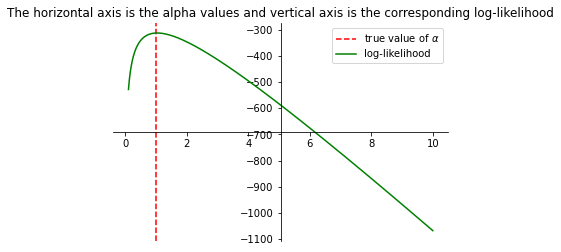

In [45]:
#Let us plot the log-likelihood function
# linearly spaced alphas
alphas = np.linspace(0.1,10,1000)
# the function as we just defined above
y = [mle_gamma(alpha, n, sample) for alpha in alphas]

fig = plt.figure()
# below taken from https://scriptverse.academy/tutorials/python-matplotlib-plot-function.html
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.axvline(x =1, color='r', linestyle='--', label = r"true value of $\alpha$")

plt.plot(alphas ,y, 'g', label = r"log-likelihood")
plt.legend()
plt.title("The horizontal axis is the alpha values and vertical axis is the corresponding log-likelihood")
# show the plot
plt.show()

In [46]:
#which (discretized!) alpha givse the maximal log-likelihood above?
alphas[np.argmax(y)]

1.0315315315315317

**Exercise Question** Do you see how the log-likelihood is shaped concave? Show that this is not coincidence.

As we know that the log-likelihood is concave, and as $\alpha \in [0.1, 10]$, we can search the optimal value by using a [bisection search](https://en.wikipedia.org/wiki/Bisection_method). We derive this next. First of all, we should derive the derivative of the log-likelihood function and set it equal to zero (even though it doesn't admit a closed form solution, we will implement a search algorithm). Denote $\psi$ as the [digamma function](https://en.wikipedia.org/wiki/Digamma_function). Hence we need:

\begin{align*}
\log(\alpha) - \psi(\alpha) - \log\left( \dfrac{1}{n} \sum_{i=1}^n x_i \right) + \dfrac{1}{n}\sum_{i=1}^n \log(x_i) = 0.
\end{align*}

Let us implement this derivative:

In [47]:
def derivative_mle_gamma(alpha, n, sample):
    '''
    Objective function - log-likelihood of the gamma distribution wrt the parameter 'alpha'
    '''
    return math.log(alpha) - psi(alpha) - math.log((1/n)* np.sum(sample)) + (1/n) * np.sum(np.log(sample))

What we observed in the plot above is that, when the log-likelihood function is concave, before it is at the global optimum value its slope is positive (hence a positive derivative), then at its global optimum value the slope is $0$, and afterwards the slope gets negative. Hence, we can apply the bisection search as follows:

In [48]:
right = 10
left = 0.1
while(abs(right - left) >= 0.00001):
    center = (right + left) / 2
    if derivative_mle_gamma(center, n, sample) > 0:
        left = center
    else:
        right = center
alpha_star = center

In [49]:
print("MLE estimation of alpha is", np.round(alpha_star,3))

MLE estimation of alpha is 1.033


Recall also that we derived
\begin{align*}
\beta^\star = \dfrac{n \alpha}{\sum_{i=1}^n x_i},
\end{align*}
hence by using $\alpha^\star$ as $\alpha$ we can also obtain $\beta^\star$:

In [50]:
beta_star = n*alpha_star / (np.sum(sample))
print("MLE estimation of beta is", np.round(beta_star,3))

MLE estimation of beta is 2.097


Not bad at alll, given that true values are $\alpha = 1, \ \beta = 2$. 

#### Let's see if the estimation is unbiased empirically.

In [51]:
np.random.seed(0) #random seed
alpha = 1 #true parameter alpha
beta = 2 #true parameter beta
n = 2000  #number of observations in a sample
simulation = 100 #how many times to simulate this experiment
alpha_star_collection = np.zeros(simulation) #vector of MLE estimates of alpha in each simulation
beta_star_collection = np.zeros(simulation)  #vector of MLE estimates of beta in each simulation
for sim in range(simulation): #simulate
    sample = np.random.gamma(alpha, (1/beta), n) #sample n iid Gamma variables
    right = 10 #bisection right-hand side
    left = 0.1 #bisection lhs
    while(abs(right - left) >= 0.00001): #until 'convergence'
        #try to understand the body of this while-loop! Does it also work like this if log-likelihood was not concave?
        center = (right + left) / 2 
        if derivative_mle_gamma(center, n, sample) > 0:
            left = center
        else:
            right = center
    alpha_star = center
    beta_star = n*alpha_star / (np.sum(sample))
    alpha_star_collection[sim] = alpha_star
    beta_star_collection[sim] = beta_star

In [52]:
round(np.mean(alpha_star_collection),3)

1.002

In [53]:
round(np.mean(beta_star_collection),3)

1.999

Overall, you will see that as $n$ increases, the estimations will converge to the true values, which is almost always the case. The reason is that we are optimizing the likelihood of the sample, and as $n$ increases, the sample will converge to the population in the sense of 'generelization'. 

However, for a fixed $n$ (e.g., $200$), increasing ```simulation``` does not converge these values to the true numbers, concluding that such a method is not necessarily unbiased. 